04_VGG19_TransferLearning_03dataset.ipynb

# Transfer Learning with VGG using the Wildfire Dataset

In this notebook I'll perform Transfer Learning on VGG19 using the [Wildfire Dataset](https://doi.org/10.3390/f14091697). 

Note this will be a **binary** classification, with images sized 128x128.

# Import Libraries

In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

In [2]:
# installed new module to show model summary
from torchinfo import summary

## Import Custom Modules

In [76]:
import sys 
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages',
 '..']

In [4]:
sys.path.append('..')

In [5]:
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages',
 '..']

# Define Hyperparameters

Here we're using the same hyperparameters as the publication minus the image size (in the paper they use 128 x 128 images)

In [6]:
BATCH_SIZE = 64
LEARNING_RATE = 0.01
N_EPOCHS = 50
N_CLASSES = 2

# to be used for height and width of final image
IMAGE_SIZE = 128

In [7]:
# Set manual seed for repeatability
RANDOM_SEED = 42
gen = torch.manual_seed(RANDOM_SEED)

# Prepare Data

## Define Custom Class and Paths

In [8]:
# Import Custom Dataset Class
from src.data.create_dataset import CustomFireImagesDataset

Define paths to dataset and annotations file

In [30]:
path_03_dataset = '../data_preprocessing/03_the_wildfire_dataset_250x250/'

annot_file_test = 'labels_03_test_dataset.csv'
annot_file_val = 'labels_03_val_dataset.csv'
annot_file_train = 'labels_03_train_dataset.csv'

In [31]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import v2

## Load Dataset and obtain Statistics

First define the transformations to get statistics

In [32]:
# Convert uint8 to float and divide by 255. 
# This is the equivalent of ToTensor() when used on a PIL image

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE))
                                 ])

In [33]:
train_dataset = CustomFireImagesDataset(annot_file_train, path_03_dataset,
                                         transform = curr_transf)

Calculate statistical properties

In [34]:
from src.data.dataset_properties import dataset_stat_prop

In [35]:
mean_train,std_train = dataset_stat_prop(train_dataset)

In [36]:
print('Statistics of Train Dataset')
print('Mean\t',mean_train)
print('STD\t',std_train)

Statistics of Train Dataset
Mean	 tensor([0.4158, 0.4036, 0.3758])
STD	 tensor([0.2733, 0.2565, 0.2799])


We'll use these values later on to normalize the inputs for training

## Define Train, Validation, and Test Data

In [37]:
# similar to before, but added an additional normalization
# according to the statistics we calculated

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE)),
                                  transforms.Normalize(mean_train,std_train)
                                 ])

In [38]:
# Define image classes
img_classes = ('non-fire','fire')
# img_classes = ('Smoke_from_fires',
#                'Both_smoke_and_fire',
#                'Forested_areas_without_confounding_elements',
#                'Fire_confounding_elements',
#                'Smoke_confounding_elements')

In [39]:
train_dataset = CustomFireImagesDataset(annot_file_train, path_03_dataset,
                                         transform = curr_transf)

val_dataset = CustomFireImagesDataset(annot_file_val, path_03_dataset,
                                         transform = curr_transf)

test_dataset = CustomFireImagesDataset(annot_file_test, path_03_dataset,
                                         transform = curr_transf)

Just a quick check

In [40]:
print('Train Dataset\t',len(train_dataset))
print('Validation Dataset\t',len(val_dataset))
print('Test Dataset\t',len(test_dataset))

Train Dataset	 1887
Validation Dataset	 402
Test Dataset	 410


In [41]:
# Next, create the DataLoaders
# Note that we're only shuffling the train dataloader

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE,
                              shuffle = True, num_workers = 4)

val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE,
                            shuffle = False, num_workers = 4)

test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE,
                             shuffle = False, num_workers = 4)

## Plot Images from Sample Batch

In [42]:
from src.visualization.plot_images import display_image_batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


non-fire  fire  fire non-fire non-fire non-fire  fire  fire non-fire  fire  fire non-fire  fire  fire non-fire  fire  fire non-fire  fire  fire non-fire non-fire  fire non-fire non-fire non-fire  fire  fire non-fire non-fire non-fire  fire  fire non-fire non-fire  fire  fire non-fire non-fire non-fire non-fire  fire non-fire non-fire non-fire non-fire  fire non-fire  fire non-fire non-fire  fire non-fire non-fire  fire non-fire non-fire non-fire non-fire  fire non-fire non-fire  fire non-fire


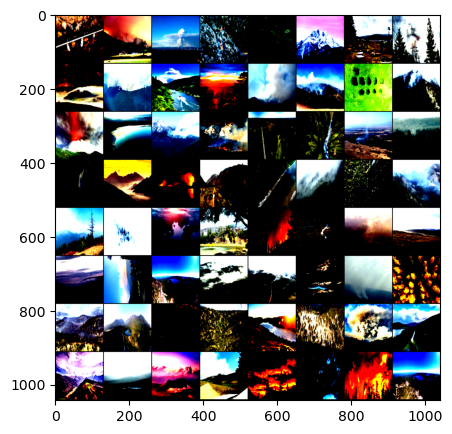

In [43]:
display_image_batch(train_dataloader,1,img_classes)

Note in a future implementation we need to adjust the figure size, as well as the labelling.

# Prepare Model (VGG19)
Here we're downloading VGG19 with the default weights used for the ImageNet classification task. We'll modify the last layer to perform transfer learning.

In [44]:
from src.models.model_transfer_learning import vgg19_transfer_learning

In [45]:
vgg19 = vgg19_transfer_learning(N_CLASSES)

# Define Optimizer and Loss Function

We'll use Adam optimizer.

In [46]:
optimizer = torch.optim.Adam(vgg19.parameters(), lr = LEARNING_RATE)

For loss function we'll use the Cross Entropy loss

In [47]:
loss_function = nn.CrossEntropyLoss()

# Import Training and Validation Loop

In [ ]:
from src.models.train_models import train_and_validate

# Define Plotting Function for loss and accuracy

In [49]:
from src.visualization.plot_model_eval import plot_loss_acc

# Train the Model

In [50]:
vgg19_trained, history = train_and_validate(vgg19,loss_function,optimizer,
                                    10,train_dataloader,val_dataloader)

10:01:23	Epoch: 1/10	Train loss: 1.0424	Val. loss: 0.8766	Train acc.: 78.17	Val. acc.: 82.07
10:04:03	Epoch: 2/10	Train loss: 0.7327	Val. loss: 0.8590	Train acc.: 82.00	Val. acc.: 76.24
10:06:41	Epoch: 3/10	Train loss: 0.8207	Val. loss: 0.8673	Train acc.: 81.66	Val. acc.: 82.89
10:09:14	Epoch: 4/10	Train loss: 0.7027	Val. loss: 0.7048	Train acc.: 84.36	Val. acc.: 84.35
10:11:51	Epoch: 5/10	Train loss: 0.6546	Val. loss: 0.8912	Train acc.: 83.74	Val. acc.: 84.20
10:14:30	Epoch: 6/10	Train loss: 0.7550	Val. loss: 0.9063	Train acc.: 84.20	Val. acc.: 84.57
10:17:07	Epoch: 7/10	Train loss: 0.7723	Val. loss: 1.2337	Train acc.: 83.89	Val. acc.: 76.59
10:19:51	Epoch: 8/10	Train loss: 0.8156	Val. loss: 1.0926	Train acc.: 85.40	Val. acc.: 81.50
10:22:25	Epoch: 9/10	Train loss: 0.6900	Val. loss: 1.2589	Train acc.: 84.21	Val. acc.: 79.27
10:25:01	Epoch: 10/10	Train loss: 0.8545	Val. loss: 1.2191	Train acc.: 84.21	Val. acc.: 80.83
Finished Training


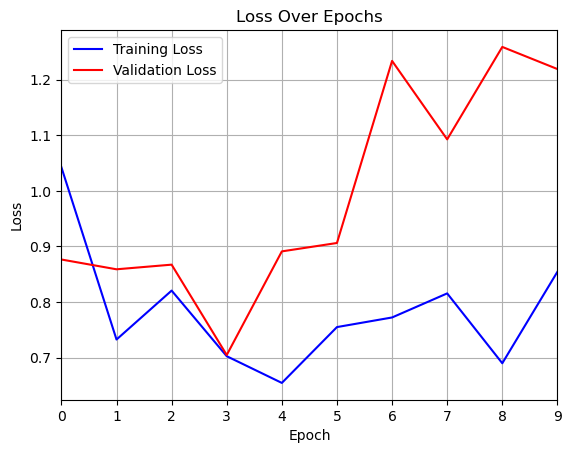

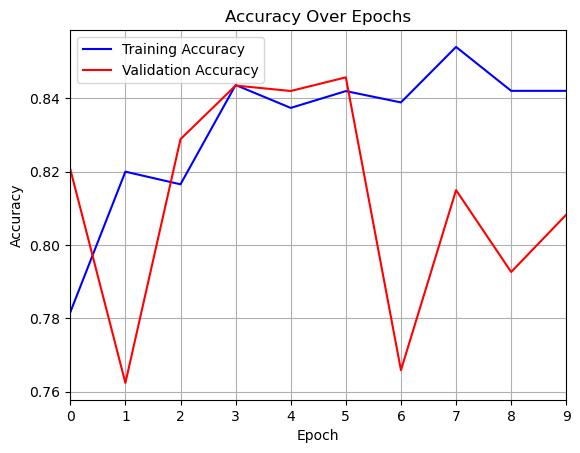

In [51]:
plot_loss_acc(history)

The model is clearly overfitting from epoch 3 onward. We'll decrease the learning rate and re-train for 10 epochs

# Train Again - Learning rate 0.001

In [52]:
vgg19_v2 = vgg19_transfer_learning(N_CLASSES)

In [53]:
optimizer = torch.optim.Adam(vgg19_v2.parameters(), lr = 0.001)

In [54]:
loss_function = nn.CrossEntropyLoss()

In [55]:
vgg19_v2_trained, history_v2 = train_and_validate(vgg19_v2,loss_function,optimizer,
                                    10,train_dataloader,val_dataloader)

10:30:51	Epoch: 1/10	Train loss: 0.4823	Val. loss: 0.4719	Train acc.: 79.09	Val. acc.: 81.20
10:33:30	Epoch: 2/10	Train loss: 0.3806	Val. loss: 0.4293	Train acc.: 83.06	Val. acc.: 81.42
10:36:04	Epoch: 3/10	Train loss: 0.3413	Val. loss: 0.4292	Train acc.: 85.03	Val. acc.: 82.64
10:38:48	Epoch: 4/10	Train loss: 0.3340	Val. loss: 0.4128	Train acc.: 85.14	Val. acc.: 83.56
10:41:28	Epoch: 5/10	Train loss: 0.3172	Val. loss: 0.4214	Train acc.: 86.39	Val. acc.: 83.33
10:44:05	Epoch: 6/10	Train loss: 0.3167	Val. loss: 0.4300	Train acc.: 85.66	Val. acc.: 81.85
10:46:38	Epoch: 7/10	Train loss: 0.3164	Val. loss: 0.4583	Train acc.: 86.07	Val. acc.: 80.70
10:49:18	Epoch: 8/10	Train loss: 0.3036	Val. loss: 0.4482	Train acc.: 86.65	Val. acc.: 82.07
10:51:57	Epoch: 9/10	Train loss: 0.2901	Val. loss: 0.4477	Train acc.: 88.17	Val. acc.: 81.50
10:54:46	Epoch: 10/10	Train loss: 0.2730	Val. loss: 0.4360	Train acc.: 87.01	Val. acc.: 83.09
Finished Training


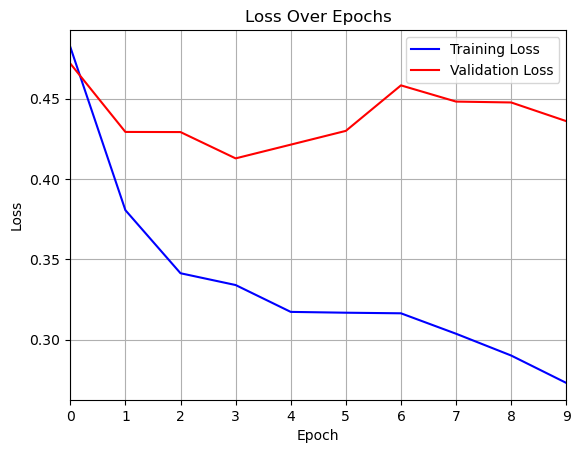

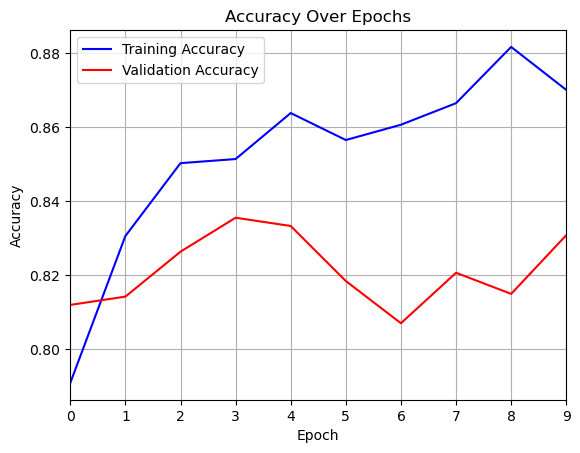

In [56]:
plot_loss_acc(history_v2)

# Even lower learning rate 0.0001

In [58]:
vgg19_v3 = vgg19_transfer_learning(N_CLASSES)

In [59]:
optimizer = torch.optim.Adam(vgg19_v3.parameters(), lr = 0.0001)

In [60]:
loss_function = nn.CrossEntropyLoss()

In [61]:
vgg19_v3_trained, history_v3 = train_and_validate(vgg19_v3,loss_function,optimizer,
                                    10,train_dataloader,val_dataloader)

11:18:51	Epoch: 1/10	Train loss: 0.5961	Val. loss: 0.5188	Train acc.: 69.25	Val. acc.: 78.20
11:21:40	Epoch: 2/10	Train loss: 0.4748	Val. loss: 0.4944	Train acc.: 79.31	Val. acc.: 78.62
11:24:22	Epoch: 3/10	Train loss: 0.4379	Val. loss: 0.4727	Train acc.: 80.76	Val. acc.: 78.75
11:27:10	Epoch: 4/10	Train loss: 0.4204	Val. loss: 0.4742	Train acc.: 80.97	Val. acc.: 79.51
11:29:59	Epoch: 5/10	Train loss: 0.4020	Val. loss: 0.4629	Train acc.: 82.50	Val. acc.: 80.53
11:32:35	Epoch: 6/10	Train loss: 0.3981	Val. loss: 0.4568	Train acc.: 81.96	Val. acc.: 80.53
11:35:08	Epoch: 7/10	Train loss: 0.3875	Val. loss: 0.4644	Train acc.: 82.33	Val. acc.: 81.52
11:37:39	Epoch: 8/10	Train loss: 0.3814	Val. loss: 0.4462	Train acc.: 82.95	Val. acc.: 80.75
11:40:17	Epoch: 9/10	Train loss: 0.3724	Val. loss: 0.4425	Train acc.: 83.11	Val. acc.: 80.75
11:42:57	Epoch: 10/10	Train loss: 0.3668	Val. loss: 0.4460	Train acc.: 83.37	Val. acc.: 81.65
Finished Training


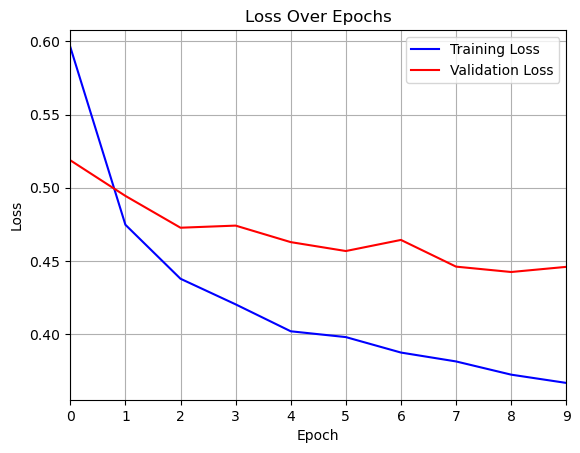

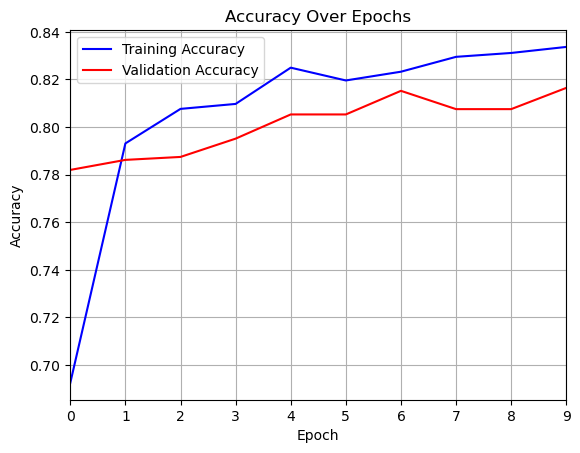

In [62]:
plot_loss_acc(history_v3)

We see that the smallest learning rate does yield a more smooth validation/test loss, so we'll use this last version of the model going forward.

## Save Model

In [80]:
# save the state model of the trained model
torch.save(vgg19_v3_trained.state_dict(), "vgg19_03dataset_trained.pt")

# Evaluate Model

We'll cycle the model over the test data and see how well the model predicts the test images. Note that we defined previously the test dataloader.

In [ ]:
# # Uncomment in case of reloading model
# vgg19_v3_trained = vgg19_transfer_learning(N_CLASSES)
# vgg19_v3_trained.load_state_dict(torch.load("vgg19_03dataset_trained.pt"))
# vgg19_v3_trained.eval()

In [91]:
from src.models.model_inference import make_hard_predictions

In [92]:
label_list,pred_list = make_predictions(vgg19_v3_trained,test_dataloader)

In [96]:
from src.visualization.plot_model_eval import calculate_conf_matrix
from src.visualization.plot_model_eval import plot_roc_curve

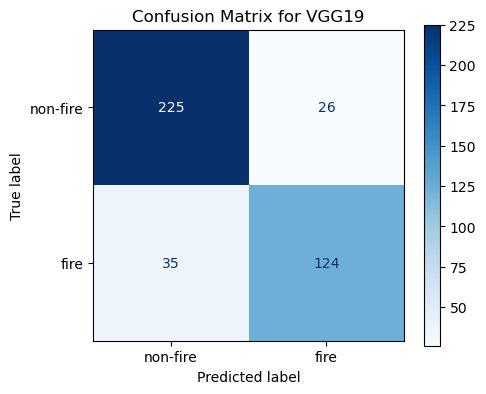

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       251
           1       0.83      0.78      0.80       159

    accuracy                           0.85       410
   macro avg       0.85      0.84      0.84       410
weighted avg       0.85      0.85      0.85       410



In [94]:
report = calculate_conf_matrix(label_list,pred_list,'VGG19',img_classes,savefig = True)

In [95]:
report = classification_report(label_list,pred_list, digits = 4)
print(report)

              precision    recall  f1-score   support

           0     0.8654    0.8964    0.8806       251
           1     0.8267    0.7799    0.8026       159

    accuracy                         0.8512       410
   macro avg     0.8460    0.8381    0.8416       410
weighted avg     0.8504    0.8512    0.8504       410



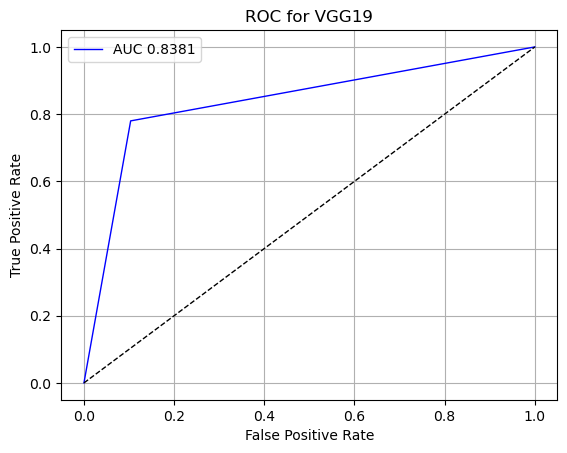

In [97]:
score = plot_roc_curve(label_list,pred_list,'VGG19')

We see that the results of the classification report match very well with what has been reported in the literature for the [Wildfire Dataset](https://doi.org/10.3390/f14091697)

|metric|MobileNetV3|VGG19|
|:---:|:---:|:---:|
|accuracy| 0.8405| 0.8512|
|precision| 0.8322| 0.8267|
|recall| 0.7799 | 0.7799|
|F1 score| 0.8049| 0.8026|
|AUC score| 0.8397| 0.8381|

Note that there is a a class imbalance in the datset, and this is only the baseline training.

# Conclusion

We've successfully performed transfer learning on VGG19 using the Wildfire Dataset.

Note there are still many False Negatives (35), so for the use case of this problem, it may be problematic.

There are other training strategies that we may explore in another notebook.